In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
encoding_dim = 14
nb_epoch = 100
batch_size = 32

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Text(0,0.5,'Frequency')

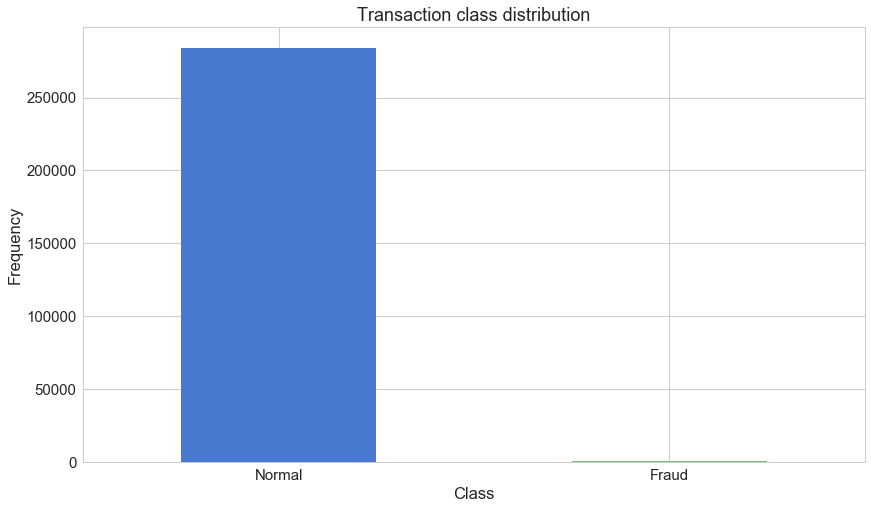

In [2]:
def get_ae(input_dim):


    return 1

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

df = pd.read_csv("D:\Python_WD\Credit_Card_Fraud_Detection/creditcard.csv")

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [3]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape
normal.shape

(284315, 31)

In [4]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))


X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values
X_train.shape
input_dim = X_train.shape[1]
autoencoder =get_ae(input_dim=input_dim)

In [5]:
def get_ae(input_dim):
    input_layer = Input(shape = (input_dim,))
    
    encoder = Dense(encoding_dim,activation = 'tanh',activity_regularizer = regularizers.l1(10e-5))(input_layer)
    encoder = Dense(int(encoding_dim /2), activation = "relu")(encoder)
    decoder = Dense(int(encoding_dim /2), activation = "tanh")(encoder)
    decoder = Dense(int(encoding_dim), activation = 'tanh')(decoder)
    decoder = Dense(input_dim,activation = "relu")(decoder)
    
    autoencoder = Model(inputs = input_layer, outputs = decoder)
    autoencoder.compile(optimizer = "adam", loss = "mean_squared_error",metrics =["accuracy"])
    print(autoencoder.summary())
    return autoencoder
                        
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)
                        
rcParams["figure.figsize"] =14,8

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_5 (Dense)              (None, 29)                435       
Total params: 1,128
Trainable params: 1,128
Non-trainable params: 0
_________________________________________________________________
None
Tra

227451/227451 [==============================] - 12s 55us/step - loss: 0.6979 - acc: 0.7061 - val_loss: 0.7363 - val_acc: 0.7155
Epoch 51/100
227451/227451 [==============================] - 12s 53us/step - loss: 0.6975 - acc: 0.7069 - val_loss: 0.7286 - val_acc: 0.7088
Epoch 52/100
227451/227451 [==============================] - 12s 54us/step - loss: 0.6974 - acc: 0.7063 - val_loss: 0.7454 - val_acc: 0.6806
Epoch 53/100
227451/227451 [==============================] - 13s 57us/step - loss: 0.6962 - acc: 0.7073 - val_loss: 0.7442 - val_acc: 0.6927
Epoch 54/100
227451/227451 [==============================] - 14s 62us/step - loss: 0.6985 - acc: 0.7073 - val_loss: 0.7296 - val_acc: 0.7113
Epoch 55/100
227451/227451 [==============================] - 13s 58us/step - loss: 0.6968 - acc: 0.7080 - val_loss: 0.7305 - val_acc: 0.7052
Epoch 56/100
227451/227451 [==============================] - 11s 50us/step - loss: 0.6961 - acc: 0.7082 - val_loss: 0.7355 - val_acc: 0.6936
Epoch 57/100
227451

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.712613,0.001720
std,3.320540,0.041443
min,0.036084,0.000000
25%,0.225809,0.000000
50%,0.377134,0.000000
75%,0.603015,0.000000
max,253.164321,1.000000


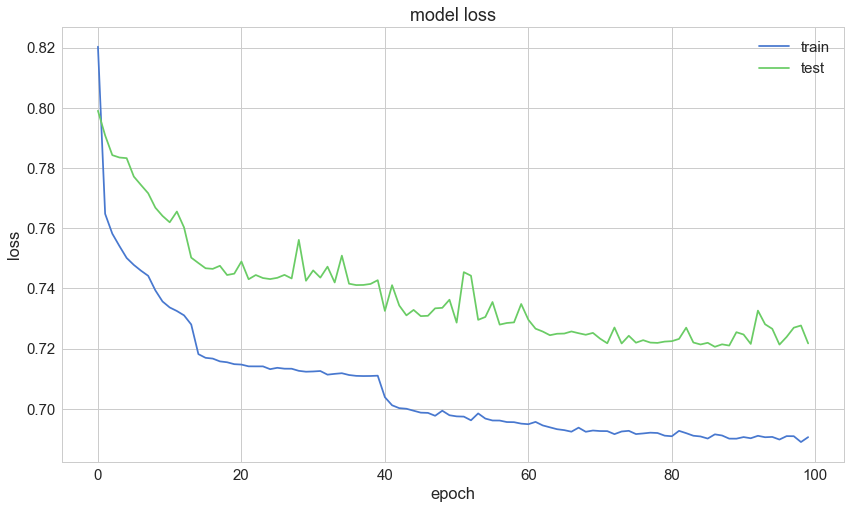

In [6]:
autoencoder =get_ae(input_dim=input_dim)

checkpointer = ModelCheckpoint(filepath="D:\Python_WD\Credit_Card_Fraud_Detection/model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='D:\Python_WD\Credit_Card_Fraud_Detection/logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

autoencoder = load_model('D:\Python_WD\Credit_Card_Fraud_Detection/model.h5')
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

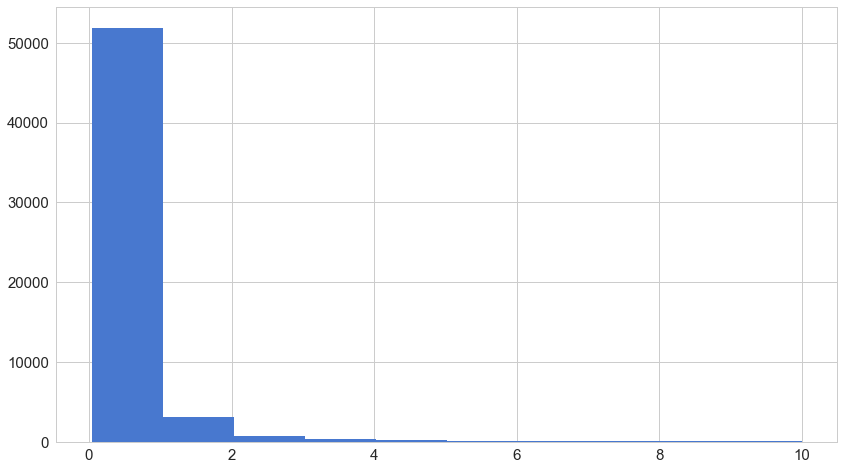

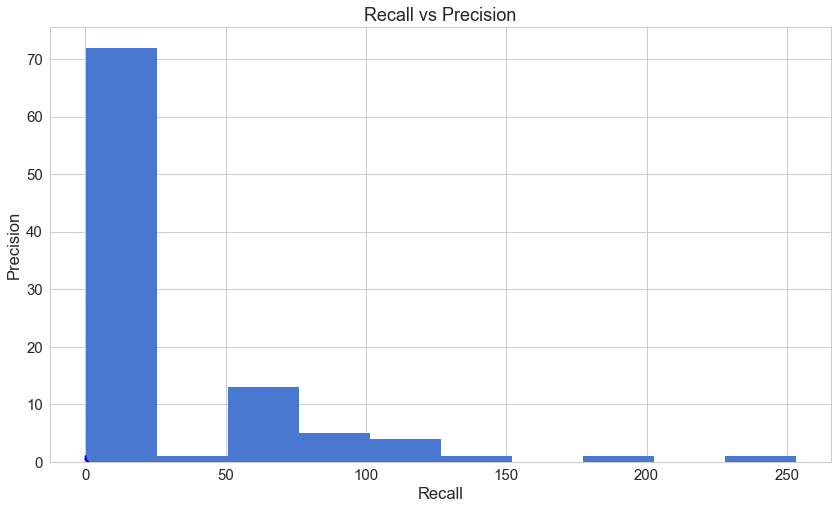

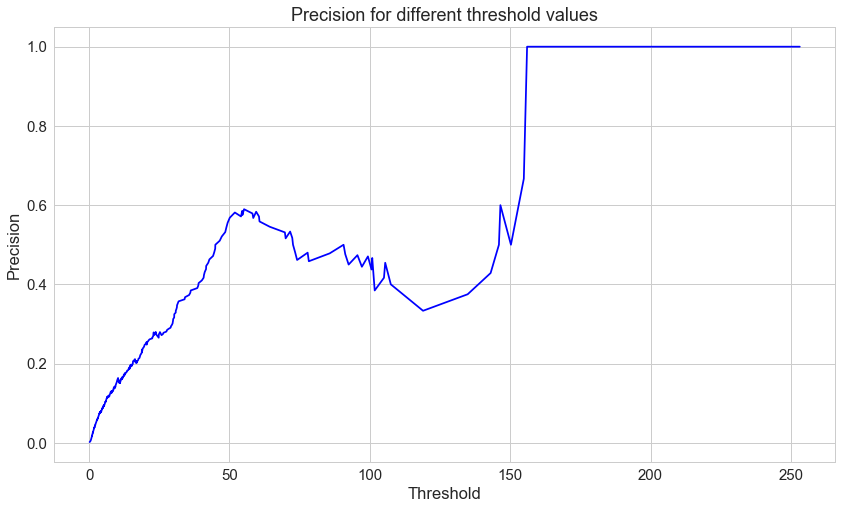

In [7]:
#w/o fraud

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)


fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

##### If the error is larger than a predefined threshold,
# we'll mark it as a fraud (since our model should have a low error on normal transactions).
threshold = 2.9

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

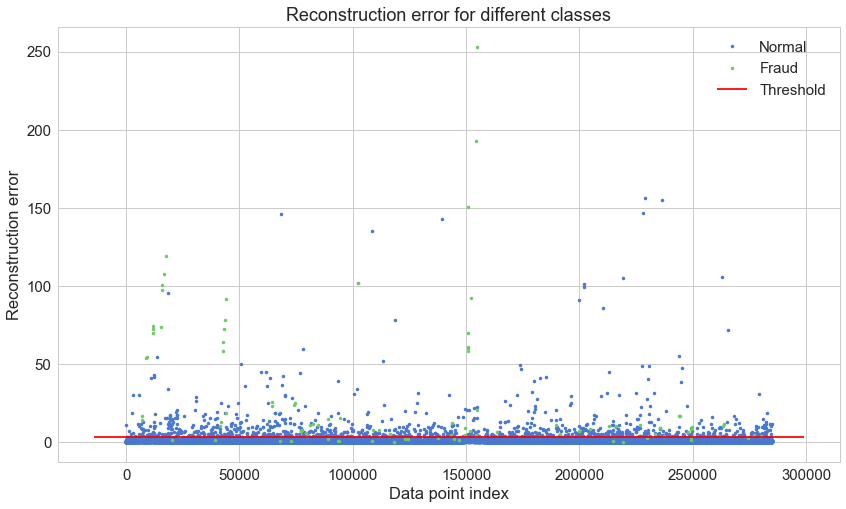

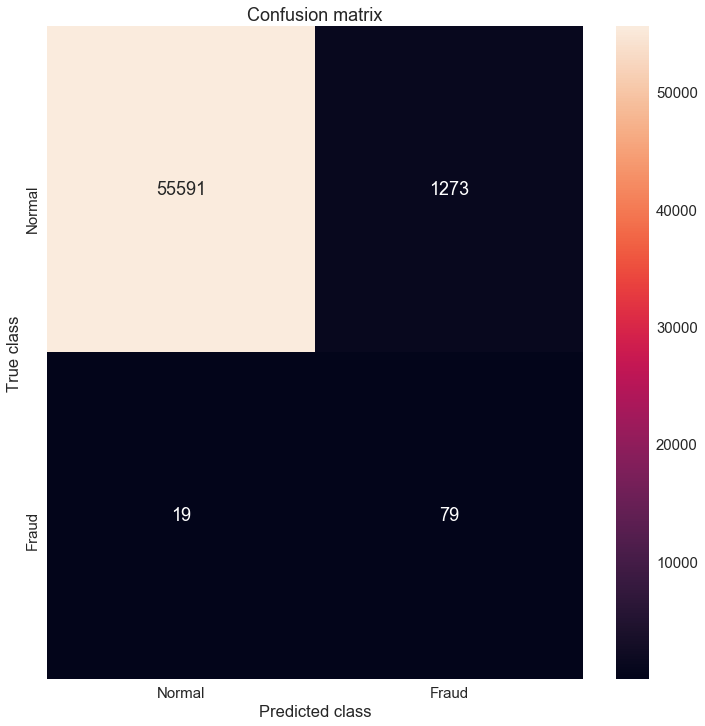

In [9]:
#If the error is larger than a predefined threshold,
# we'll mark it as a fraud (since our model should have a low error on normal transactions).
threshold = 2.9

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()